In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm

### READING THE DATASET

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/Text_EnglishToHindi/7/Hindi_English_Truncated_Corpus.csv')
df.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [ ]:
df.drop(columns=['source'],inplace=True)

In [ ]:
df = df.iloc[:10000,:]
df.head()

,english_sentence,hindi_sentence
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


### PREPROCESSING



1.   FUNCTIONS TO CLEAN THE ENGLISH AND HINDI SENTENCES



In [ ]:
def cleanerEng(x):
  x = str(x)
  x = x.lower()
  x = re.sub(r'[^a-z0-9]+',' ',x)
  if len(x) > 150:
    x = x[:150]
  return x

def cleanerHindi(x):
  x = str(x)
  x = re.sub(r'[-.।|,?;:<>&$₹]+',' ',x)
  if len(x) > 150:
    x = x[:150]
  return x

In [ ]:
df.iloc[:,0] = df['english_sentence'].apply(func=cleanerEng)
df.iloc[:,1] = df['hindi_sentence'].apply(func= cleanerHindi)
df.iloc[:,0] = df['english_sentence'].apply(func= lambda x : (str(x).split()))
df.iloc[:,1] = df['hindi_sentence'].apply(func= lambda x : (str(x).split()))

2.   ADDING < START > AND < END > TOKENS



In [ ]:
def addTokens(x,start=False):
  x.append('<END>')
  if start:
    x.insert(0,'<START>')
  return list(x)

In [ ]:
df.iloc[:,0] = df['english_sentence'].apply(func= addTokens,start=False)
df.iloc[:,1] = df['hindi_sentence'].apply(func= addTokens,start=True)

In [ ]:
df.iloc[79,1]

['<START>',
 'जो',
 'वह',
 'सीखता',
 'है',
 'या',
 'पूर्व',
 'क्रमादेशित',
 'होता',
 'है',
 '<END>']

3.   CREATING ENGLISH AND HINDI VOCABULARY

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

In [ ]:
data = df.values

In [ ]:
data[:,1].shape

(10000,)

In [ ]:
class vocab:

  def __init__(self,data,token=True):
    self.data = data
    if token:
      self.word2idx = {'<START>':1, '<END>':2, '<PAD>':0}
      self.idx2word = {1:'<START>', 2:'<END>', 0:'<PAD>'}
      self.idx = 2

    else:
      self.word2idx = {'<PAD>':0, '<END>':1}
      self.idx2word = {0:'<PAD>', 1:'<END>'}
      self.idx = 1

    self.x = []
    self.create()
    self.vocab_size = self.idx + 1

  def create(self):
    max_len = 0;
    for sentence in  self.data:
      max_len = max(max_len, len(sentence))
      for word in sentence:
        if self.word2idx.get(word) is None:
          self.idx += 1
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
    
    for sentence in self.data:
      sent = []
      for word in sentence:
        sent.append(self.word2idx[word])
      
      for i in range(len(sentence),max_len+1):
        sent.append(0)
      
      self.x.append(torch.Tensor(sent))

In [ ]:
English_vocab = vocab(data[:,0],token=False)
Hindi_vocab = vocab(data[:,1],token=True)

In [ ]:
for idx in Hindi_vocab.x[2]:
  print(Hindi_vocab.idx2word[int(idx)],end=' ')

<START> यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

In [ ]:
class parallelData(Dataset):

  def __init__(self):
    self.x = English_vocab.x
    self.y = Hindi_vocab.x

  def __getitem__(self,i):
    return self.x[i], self.y[i]
  
  def __len__(self):
    return len(self.x)

In [ ]:
dataset = parallelData()

In [ ]:
a = dataset[0][0].shape[0]
b = dataset[0][1].shape[0]
for i in range(len(dataset)):
  if a != dataset[i][0].shape[0] or b != dataset[i][1].shape[0]:
    print(a,dataset[i][0].shape[0],b,dataset[i][1].shape[0])

In [ ]:
Hindi_vocab.x[90].shape

torch.Size([42])

### MODEL PREPARATION



1.   ENCODER
2.   DECODER
3.   MODEL - ATTNSEQ2SEQ



In [ ]:
class encoder(nn.Module):

  def __init__(self, input_size, embedding_size, hidden_size, layers, bidirectional):
    '''
    input_size = size of vocab
    embedding_size = embedding dim
    hidden_size = hidden state size
    layer = num of layers of lstms
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True, bidirectional = bidirectional)
    self.bidirectional = bidirectional
    self.fc_hidden = nn.Linear(hidden_size*2, hidden_size)
    self.fc_cell = nn.Linear(hidden_size*2, hidden_size)

  def forward(self,x):
    '''
    x shape = [batch_size, sentence]
    one complete sentence represents a "sequence"
    '''
    x = self.embed(x) # shape [batch_size,  sentence, embed_size]
    output, (hidden_state, cell_state) = self.lstm(x) #shape [batch_size, seq_len, num_directions(2)*hidden_size]

    if self.bidirectional:  #since we have 2 directions so add(concat) hidden of both directions into one
      hidden = torch.cat((hidden_state[0:1], hidden_state[1:2]), dim=2)
      cell = torch.cat((cell_state[0:1], cell_state[1:2]), dim = 2) #output [1(layer), batch, hidden_size*2]
      hidden_state = self.fc_hidden(hidden)
      cell_state = self.fc_cell(cell)

    return output, hidden_state, cell_state

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
class decoder(nn.Module):

  def __init__(self,input_size, embedding_size, hidden_size, layers):
    '''
    same configuration as encoder
    here input_size = size of hindi vocab
    '''
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among hindi vocab therefore out_feature=input_size

  def forward(self,x,hidden_state, cell_state):
    '''
    seq_len would be 1 as input is  one word not the whole sentence
    x = [batch_size] ->required-> [batch_size, 1] (1 is seq_len)
    '''
    # print(x.shape)
    x = x.reshape(-1,1) # shape [batch, 1]
    # print(x.shape)
    x = self.embed(x) # shape [batch, 1, embed_dim]

    output, (hidden_state, cell_state) = self.lstm(x, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, hindi_vocab_size]
    
    #removing extra dim
    output = output.squeeze(dim=1) #shape [batch, hindi_vocab_size]

    return output, hidden_state, cell_state


##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class AttnDecoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, layers):
    super().__init__()

    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=hidden_size*2 + embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among hindi vocab therefore out_feature=input_size

    #encoder_states from encoder => [batch, seq_len(35), 2*hidden_size]
    #prev decoder hidden_state => [batch, layers(1)*directions(2), hidden_size] =>need to be in => [batch, seq(35), hidden_size]
    #therefore input of energy will be along hidden_size ie input = hidden_size*2
    self.energy =  nn.Linear(hidden_size*3, 1) #out [batch, seq_len, 1] (2 hidden state from bidirectional encoder and 1 from prev decoder hidden state => 1+2= 3 hidden states as input)
    self.softmax = nn.Softmax(dim=1)# doing softmax for each word ie (dim=1)

  
  def forward(self, x, hidden_state, cell_state, encoder_states):
    # print(encoder_states.shape)
    seq_len = encoder_states.shape[1]
    batch_size = encoder_states.shape[0]
    hidden_size = encoder_states.shape[2]

    h_new = hidden_state.repeat(seq_len, 1, 1) #shape [seq_len*1, batch, hidden_size*2(bidirectional)] it will repeat dim=0 seq length times
    #by doing .repeat operation we can concat hidden state with all timestamps of encoder_states
    # print(h_new.shape, encoder_states.shape, hidden_state.shape)
    h_new = h_new.permute(1,0,2) #[batch, seq_len, hidden_size*2]
    energy = self.energy(torch.cat((h_new, encoder_states), dim=2))#input [batch, seq_len(35), hidden_size*3]  out = [batch, seq_len(35), 1]
    att_weights = self.softmax(energy)
    att_weights = att_weights.permute(0,2,1) # [batch, 1, seq_len]

    context = torch.bmm(att_weights, encoder_states) #[batch, 1, hidden_size*2]
    

    x = x.reshape(-1,1) # shape [batch, 1]
    x = self.embed(x) # shape [batch, 1, embed_dim]

    input_new = torch.cat((context, x), dim=2) #[batch, 1, hidden_size*2 +embed_dim]

    output, (hidden_state, cell_state) = self.lstm(input_new, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, hindi_vocab_size]

    output = output.squeeze(dim=1) #shape [batch, hindi_vocab_size]
    del h_new
    del context
    del input_new
    return output, hidden_state, cell_state

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class seq2seq(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder


  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of english sentences[batch, sentece(padded)]
    target = batch of hindi sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    hindi_vocab_size = Hindi_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, hindi_vocab_size)).to(device)

    _, hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token

    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)#max value(confidence)  shape = [batch of words]

      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    
    return output  #shape[seq_len, batch_size, vocab_size]

##_---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class Attnseq2seq(nn.Module):
  def __init__(self, encoder, att_decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = att_decoder


  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of english sentences[batch, sentece(padded)]
    target = batch of hindi sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    hindi_vocab_size = Hindi_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, hindi_vocab_size)).to(device)

    encoder_states, hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token

    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]

      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    
    return output  #shape[seq_len, batch_size, vocab_size]



4.   TRAINING



In [ ]:
##training
epochs = 120
learning_rate = 0.0006
batch_size = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_size = 256
hidden_size = 256
layers = 1
bidirection = True

In [ ]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
ENC = encoder(English_vocab.vocab_size, embedding_size, hidden_size, layers, bidirection).to(device)
# DE = decoder(Hindi_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
DE = AttnDecoder(Hindi_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)
# model = seq2seq(ENC,DE).to(device)
model = Attnseq2seq(ENC,DE).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
train_loss = []
for epoch in tqdm(range(epochs)):
  for id,(x,y) in (enumerate(tqdm(loader))):
    x = x.long().to(device)
    y = y.long().to(device)#[batch,seq]

    output = model(x,y,1)# [seq, batch, vocab]
    output = output[1:].reshape(-1,output.shape[2])
    y = y.permute(1,0)#[seq, batch]
    y = y[1:].reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output,y)

    loss.backward()
    optimizer.step()

    # if id%20 == 0:
  print(f'[{epoch+1}/{epochs}] loss=>{loss.item()}')
  train_loss.append(loss.item())  


[1/120] loss=>7.332956314086914



[2/120] loss=>6.937061309814453



[3/120] loss=>6.784578323364258



[4/120] loss=>6.611599922180176



[5/120] loss=>6.440646171569824



[6/120] loss=>6.396508693695068



[7/120] loss=>6.109786033630371



[8/120] loss=>5.961916923522949



[9/120] loss=>5.682298183441162



[10/120] loss=>5.700921058654785



[11/120] loss=>5.637402534484863



[12/120] loss=>5.303717136383057



[13/120] loss=>5.182213306427002



[14/120] loss=>5.225167751312256



[15/120] loss=>5.050327777862549



[16/120] loss=>4.857426166534424



[17/120] loss=>4.776157379150391



[18/120] loss=>4.530791282653809



[19/120] loss=>4.464898109436035



[20/120] loss=>4.306596755981445



[21/120] loss=>4.232858657836914



[22/120] loss=>4.066902160644531



[23/120] loss=>3.9159250259399414



[24/120] loss=>3.913543939590454



[25/120] loss=>3.8184845447540283



[26/120] loss=>3.643368721008301



[27/120] loss=>3.4866466522216797



[28/120] loss=>3.383664608001709



[29/120] loss=>3.2064247131347656



[30/120] loss=>3.055943012237549



[31/120] loss=>3.1166627407073975



[32/120] loss=>2.9149906635284424



[33/120] loss=>2.7592391967773438



[34/120] loss=>2.593066453933716



[35/120] loss=>2.6344525814056396



[36/120] loss=>2.4766199588775635



[37/120] loss=>2.278973340988159



[38/120] loss=>2.258941173553467



[39/120] loss=>2.104405403137207



[40/120] loss=>2.138505458831787



[41/120] loss=>2.040212631225586



[42/120] loss=>1.9060356616973877



[43/120] loss=>1.7995859384536743



[44/120] loss=>1.7434130907058716



[45/120] loss=>1.7916091680526733



[46/120] loss=>1.5506973266601562



[47/120] loss=>1.4925271272659302



[48/120] loss=>1.340794324874878



[49/120] loss=>1.3663136959075928



[50/120] loss=>1.2703803777694702



[51/120] loss=>1.2505334615707397



[52/120] loss=>1.132081389427185



[53/120] loss=>1.161059856414795



[54/120] loss=>1.1162625551223755



[55/120] loss=>1.0643727779388428



[56/120] loss=>0.9909517765045166



[57/120] loss=>0.9292950630187988



[58/120] loss=>0.906167209148407



[59/120] loss=>0.8966538906097412



[60/120] loss=>0.8564957976341248



[61/120] loss=>0.7511351704597473



[62/120] loss=>0.647306501865387



[63/120] loss=>0.658900260925293



[64/120] loss=>0.6352962851524353



[65/120] loss=>0.6185036897659302



[66/120] loss=>0.5864903926849365



[67/120] loss=>0.4944705665111542



[68/120] loss=>0.5287624001502991



[69/120] loss=>0.5465556979179382



[70/120] loss=>0.4593107998371124



[71/120] loss=>0.4188443124294281



[72/120] loss=>0.40531718730926514



[73/120] loss=>0.341096431016922



[74/120] loss=>0.3251802325248718



[75/120] loss=>0.33472737669944763



[76/120] loss=>0.3385251760482788



[77/120] loss=>0.25228801369667053



[78/120] loss=>0.25016671419143677



[79/120] loss=>0.2709498405456543



[80/120] loss=>0.22379383444786072



[81/120] loss=>0.23391138017177582



[82/120] loss=>0.21799252927303314



[83/120] loss=>0.20573662221431732



[84/120] loss=>0.16965363919734955



[85/120] loss=>0.15572279691696167



[86/120] loss=>0.14436295628547668



[87/120] loss=>0.1555032730102539



[88/120] loss=>0.1411466896533966



[89/120] loss=>0.12698888778686523



[90/120] loss=>0.11494197696447372



[91/120] loss=>0.1155739426612854



[92/120] loss=>0.11393357813358307



[93/120] loss=>0.1003059595823288



[94/120] loss=>0.09055258333683014



[95/120] loss=>0.08548835664987564



[96/120] loss=>0.07843302190303802



[97/120] loss=>0.06919946521520615



[98/120] loss=>0.0868251696228981



[99/120] loss=>0.06634347140789032



[100/120] loss=>0.06473639607429504



[101/120] loss=>0.05510811507701874



[102/120] loss=>0.061254292726516724



[103/120] loss=>0.04806409776210785



[104/120] loss=>0.05352764204144478



[105/120] loss=>0.05707593634724617



[106/120] loss=>0.07657613605260849



[107/120] loss=>0.11787550896406174



[108/120] loss=>0.18557201325893402



[109/120] loss=>0.15761925280094147



[110/120] loss=>0.09574172645807266



[111/120] loss=>0.0632530227303505



[112/120] loss=>0.04268963262438774



[113/120] loss=>0.03237176313996315



[114/120] loss=>0.027110720053315163



[115/120] loss=>0.02429615519940853



[116/120] loss=>0.027586456388235092



[117/120] loss=>0.02221340499818325



[118/120] loss=>0.022195128723978996



[119/120] loss=>0.024681825190782547



[120/120] loss=>0.019648054614663124



5. EPOCHS VS LOSS

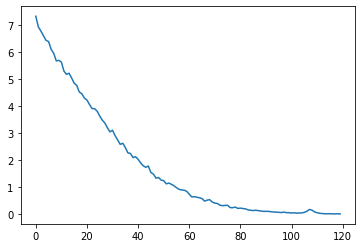

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()
plt.savefig('/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/Text_EnglishToHindi/7/epochVtrain_loss.png')

6. SAVE THE MODEL
7. LOAD THE MODEL

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/Text_EnglishToHindi/7/model.pt')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/Text_EnglishToHindi/7/model.pt'))

<All keys matched successfully>

8. MODEL SUMMARY

In [ ]:
model.eval()

Attnseq2seq(
  (encoder): encoder(
    (embed): Embedding(16978, 256)
    (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
    (fc_hidden): Linear(in_features=512, out_features=256, bias=True)
    (fc_cell): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): AttnDecoder(
    (embed): Embedding(20376, 256)
    (lstm): LSTM(768, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=20376, bias=True)
    (energy): Linear(in_features=768, out_features=1, bias=True)
    (softmax): Softmax(dim=1)
  )
)

### PREDICTION
```ALONG WITH THE INDIVIDUAL BLEU SCORES```

In [ ]:
def prediction(x):
    for idx in x:
      if idx == 0:
        break
      print(English_vocab.idx2word[int(idx)],end=' ')
    
    print()
  
    x = x.long().reshape(1,-1).to(device)
    ans = translate(x)
    res = []
    for id in ans:
      res.append(Hindi_vocab.idx2word[id])
    
    return res

In [ ]:
def translate(input):
      #input = batch of english sentences[batch, sentece(padded)]
      with torch.no_grad():
        guess = []
        encoder_states, hidden, cell = model.encoder(input)
        # x = torch.ones((1)).float().to(device) # <START> token
        x = torch.ones((1)).long().to(device)
        while True:
          out, hidden, cell = model.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
          x = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]
          guess.append(int(x[0].detach().cpu()))

          if x == 2:
            break

      return guess

In [ ]:
import nltk
import warnings
warnings.filterwarnings('ignore')

In [ ]:
k=random.randint(0,10000)
print('Input English sentence:',end=' ')
candidate = prediction(dataset[k][0])
refer = df.iloc[k,1][1:]
bleu1 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Actual Hindi Translation:', refer)
print('Predicted Hindi Translation:', candidate)
print(bleu1)

Input English sentence: and torture s a terrible enough thing as it is but when it s done by your hero <END> 
Actual Hindi Translation: ['और', 'यंत्रणा', 'तो', 'वैसी', 'ही', 'प्रचंड', 'चीज़', 'है', 'मगर', 'जब', 'आपके', 'आदर्श', 'हीरो', 'के', 'हाथों', 'हो', '<END>']
Predicted Hindi Translation: ['और', 'यंत्रणा', 'तो', 'वैसी', 'ही', 'प्रचंड', 'चीज़', 'है', 'मगर', 'जब', 'आपके', 'आदर्श', 'हीरो', 'के', 'हाथों', 'हो', '<END>']
1.0


In [ ]:
k=random.randint(0,10000)
print('Input English sentence:',end=' ')
candidate = prediction(dataset[k][0])
refer = df.iloc[k,1][1:]
bleu2 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Actual Hindi Translation:', refer)
print('Predicted Hindi Translation:', candidate)
print(bleu2)

Input English sentence: and you have people who guide those computers <END> 
Actual Hindi Translation: ['लोग', 'हैं', 'उन', 'कंप्यूटरों', 'के', 'मार्गदर्शन', '<END>']
Predicted Hindi Translation: ['लोग', 'हैं', 'उन', 'कंप्यूटरों', 'के', 'मार्गदर्शन', '<END>']
1.0


In [ ]:
k=random.randint(0,10000)
print('Input English sentence:',end=' ')
candidate = prediction(dataset[k][0])
refer = df.iloc[k,1][1:]
bleu3 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Actual Hindi Translation:', refer)
print('Predicted Hindi Translation:', candidate)
print(bleu3)

Input English sentence: temperature of the lower troposphere has increased by 0 12 to 0 22 degrees c 0 22 to 0 4 degrees f every decade as per the satellite temperature measu <END> 
Actual Hindi Translation: ['निचले', 'त्रोपोस्फेरे', '(troposphere)में', 'तापमान', '0', '12', 'और', '0', '22', '°C', '(', '(0', '22', 'और', '0', '4', '°F)', 'के', 'बीच', 'में', 'प्रति', 'दशक', 'बड़ा', 'है', 'जैसा', 'की', 'उपग्रह', 'के', 'आंकडे', 'बताते', 'हैं', '(satell', '<END>']
Predicted Hindi Translation: ['निचले', 'त्रोपोस्फेरे', '(troposphere)में', 'तापमान', '0', '12', 'और', '0', '22', '°C', '(', '(0', '22', 'और', '0', '4', '°F)', 'के', 'बीच', 'में', 'प्रति', 'दशक', 'बड़ा', 'है', 'जैसा', 'की', 'उपग्रह', 'के', 'आंकडे', 'बताते', 'हैं', '(satell', '<END>']
1.0


In [ ]:
k=random.randint(0,10000)
print('Input English sentence:',end=' ')
candidate = prediction(dataset[k][0])
refer = df.iloc[k,1][1:]
bleu4 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Actual Hindi Translation:', refer)
print('Predicted Hindi Translation:', candidate)
print(bleu4)

Input English sentence: a student missed 18 <END> 
Actual Hindi Translation: ['एक', 'बच्चे', 'ने', '१८', 'गलत', 'जवाब', 'दिये', '<END>']
Predicted Hindi Translation: ['एक', 'बच्चे', 'ने', '१८', 'गलत', 'जवाब', 'दिये', '<END>']
1.0


In [ ]:
k=random.randint(0,10000)
print('Input English sentence:',end=' ')
candidate = prediction(dataset[k][0])
refer = df.iloc[k,1][1:]
bleu5 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Actual Hindi Translation:', refer)
print('Predicted Hindi Translation:', candidate)
print(bleu5)

Input English sentence: he took her love and devotion for granted <END> 
Actual Hindi Translation: ['उन्होंने', 'उसके', 'प्रेम', 'और', 'समर्पण', 'के', 'प्रति', 'ध्यान', 'नहीं', 'दिया', 'उसे', 'स्वाभाविक', 'ही', 'समझा', '<END>']
Predicted Hindi Translation: ['उन्होंने', 'उसके', 'प्रेम', 'और', 'समर्पण', 'के', 'प्रति', 'ध्यान', 'नहीं', 'दिया', 'उसे', 'स्वाभाविक', 'ही', 'समझा', '<END>']
1.0


In [ ]:
k=random.randint(0,10000)
print('Input English sentence:',end=' ')
candidate = prediction(dataset[k][0])
refer = df.iloc[k,1][1:]
bleu6 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Actual Hindi Translation:', refer)
print('Predicted Hindi Translation:', candidate)
print(bleu6)

Input English sentence: of a rich man who sat in synagogue one day <END> 
Actual Hindi Translation: ['एक', 'धनवान', 'व्यक्ति', 'की', 'जो', 'एक', 'दिन', 'एक', 'आराधनालय', '(पूजा', 'स्थल)', 'में', 'बैठा', '<END>']
Predicted Hindi Translation: ['एक', 'धनवान', 'व्यक्ति', 'की', 'जो', 'एक', 'दिन', 'एक', 'आराधनालय', '(पूजा', 'स्थल)', 'में', 'बैठा', '<END>']
1.0


In [ ]:
k=random.randint(0,10000)
print('Input English sentence:',end=' ')
candidate = prediction(dataset[k][0])
refer = df.iloc[k,1][1:]
bleu7 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Actual Hindi Translation:', refer)
print('Predicted Hindi Translation:', candidate)
print(bleu7)

Input English sentence: after the victory of jangbahadur he founded the rana dynasty and implemented the rana rule <END> 
Actual Hindi Translation: ['जंगबहादुर', 'की', 'जीत', 'के', 'बाद', 'राणा', 'खानदान', 'उन्होने', 'सुरुकिया', 'व', 'राणा', 'शासन', 'लागु', 'किया', '<END>']
Predicted Hindi Translation: ['जंगबहादुर', 'की', 'जीत', 'के', 'बाद', 'राणा', 'खानदान', 'उन्होने', 'सुरुकिया', 'व', 'राणा', 'शासन', 'लागु', 'किया', '<END>']
1.0


In [ ]:
k=random.randint(0,10000)
print('Input English sentence:',end=' ')
candidate = prediction(dataset[k][0])
refer = df.iloc[k,1][1:]
bleu8 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Actual Hindi Translation:', refer)
print('Predicted Hindi Translation:', candidate)
print(bleu8)

Input English sentence: transport <END> 
Actual Hindi Translation: ['यातायात', '<END>']
Predicted Hindi Translation: ['यातायात', '<END>']
1.0


In [ ]:
k=random.randint(0,10000)
print('Input English sentence:',end=' ')
candidate = prediction(dataset[k][0])
refer = df.iloc[k,1][1:]
bleu9 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Actual Hindi Translation:', refer)
print('Predicted Hindi Translation:', candidate)
print(bleu9)

Input English sentence: passable government <END> 
Actual Hindi Translation: ['कामचलाऊ', 'सरकार', '<END>']
Predicted Hindi Translation: ['कामचलाऊ', 'सरकार', '<END>']
1.0


In [ ]:
k=random.randint(0,10000)
print('Input English sentence:',end=' ')
candidate = prediction(dataset[k][0])
refer = df.iloc[k,1][1:]
bleu10 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Actual Hindi Translation:', refer)
print('Predicted Hindi Translation:', candidate)
print(bleu10)

Input English sentence: in 33 year of creative life he give the literature legacy which is a invaluable as a quality point of view and point of shape it is infinity <END> 
Actual Hindi Translation: ['तैंतीस', 'वर्षों', 'के', 'रचनात्मक', 'जीवन', 'में', 'वे', 'साहित्य', 'की', 'ऐसी', 'विरासत', 'सौप', 'गए', 'जो', 'गुणों', 'की', 'दृष्टि', 'से', 'अमूल्य', 'है', 'और', 'आकार', 'की', 'दृष्टि', 'से', 'असीमित', '<END>']
Predicted Hindi Translation: ['तैंतीस', 'वर्षों', 'के', 'रचनात्मक', 'जीवन', 'में', 'वे', 'साहित्य', 'की', 'ऐसी', 'विरासत', 'सौप', 'गए', 'जो', 'गुणों', 'की', 'दृष्टि', 'से', 'अमूल्य', 'है', 'और', 'आकार', 'की', 'दृष्टि', 'से', 'असीमित', '<END>']
1.0


### AVERAGE BLEU SCORE

In [ ]:
#BLEU Score
bleu = (bleu1+bleu2+bleu3+bleu4+bleu5+bleu6+bleu7+bleu8+bleu9+bleu10)/10
print('Average BLEU Score of the Model:', bleu)

Average BLEU Score of the Model: 1.0
